# Analysis of a Long Straddle Strategy on SPY Options  
## Payoff, Delta Hedging and Execution Risk

**Author:** MARCO CORPA CRIADO  
**Tools:** Python, Interactive Brokers API, Black–Scholes  
**Date:** 04/01/2026


## 1. Introduction

Options strategies play a central role in modern derivatives markets, particularly for managing nonlinear risk exposures. Among these strategies, the **long straddle** is widely used to express views on volatility rather than on directional price movements.

A long straddle consists of simultaneously purchasing:
- a call option
- a put option

with the same strike price and maturity. This structure results in a payoff that is convex with respect to the underlying asset price and largely direction-neutral.

The objective of this project is to analyze a long straddle strategy on **SPY options** from both a theoretical and practical perspective. The analysis covers:
1. payoff characteristics,
2. delta hedging under the Black–Scholes framework, and
3. execution (legging) risk when entering multi-leg option positions.

The Interactive Brokers (IBKR) API is used to retrieve option chain information and construct the strategy, while pricing and risk analysis are conducted through quantitative simulations in Python.


## 2. Market and Instrument Description

The underlying instrument considered in this study is **SPY**, an exchange-traded fund tracking the S&P 500 index. SPY options are among the most liquid equity options worldwide, making them well suited for both academic analysis and practical implementation.

Key characteristics of SPY options:
- American-style exercise
- Physical settlement
- Contract multiplier of 100
- High liquidity across multiple expirations and strikes

Option chain information, including available strikes, expirations, and contract identifiers, is retrieved directly from Interactive Brokers using the IBKR API.


In [1]:
import sys
import numpy as np
import pandas as pd

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)


Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
NumPy: 2.3.4
Pandas: 2.3.3


In [2]:
import ib_insync
import py_vollib
import importlib.metadata as md

print("ib_insync:", ib_insync.__version__)

try:
    print("py_vollib:", md.version("py_vollib"))
except md.PackageNotFoundError:
    print("py_vollib: version not found via metadata")


ib_insync: 0.9.86
py_vollib: 1.0.1


In [3]:
import nest_asyncio
nest_asyncio.apply()


In [5]:
from ib_insync import IB

HOST = "127.0.0.1"
PORT = 7497
CLIENT_ID = 100  # usa uno alto para notebooks

ib = IB()
ib.connect(HOST, PORT, clientId=CLIENT_ID, timeout=5)

print("Connected:", ib.isConnected())

ib.disconnect()
print("Disconnected:", not ib.isConnected())


Connected: True
Disconnected: True


In [6]:
from ib_insync import IB, Stock

HOST = "127.0.0.1"
PORT = 7497
CLIENT_ID = 100  # notebook id

ib = IB()
ib.connect(HOST, PORT, clientId=CLIENT_ID, timeout=5)
print("Connected:", ib.isConnected())

spy = Stock("SPY", "SMART", "USD", primaryExchange="ARCA")
ib.qualifyContracts(spy)

print("SPY conId:", spy.conId)


Connected: True
SPY conId: 756733


In [7]:
chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
print("Total chains:", len(chains))

chain = next(
    c for c in chains
    if c.tradingClass == "SPY" and c.multiplier == "100" and c.exchange == "SMART"
)

expirations = sorted(chain.expirations)
strikes = sorted(chain.strikes)

print("Selected chain:")
print("  Exchange     :", chain.exchange)
print("  TradingClass :", chain.tradingClass)
print("  Multiplier   :", chain.multiplier)

print("\nFirst expirations:", expirations[:10])
print("First strikes:", strikes[:15])


Total chains: 39
Selected chain:
  Exchange     : SMART
  TradingClass : SPY
  Multiplier   : 100

First expirations: ['20260105', '20260106', '20260107', '20260108', '20260109', '20260112', '20260113', '20260114', '20260115', '20260116']
First strikes: [50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 105.0, 110.0, 115.0, 120.0]


In [ ]:
##  Monthly Expiration Selection

from datetime import datetime, date
import calendar

def third_friday(year: int, month: int) -> date:
    cal = calendar.Calendar(firstweekday=calendar.MONDAY)
    fridays = [d for d in cal.itermonthdates(year, month)
               if d.month == month and d.weekday() == calendar.FRIDAY]
    return fridays[2]

def pick_expiry_monthly(expirations):
    expirations = sorted(expirations)
    exp_dates = [datetime.strptime(x, "%Y%m%d").date() for x in expirations]

    start = exp_dates[0]
    y, m = start.year, start.month

    for _ in range(12):
        tf = third_friday(y, m)
        if tf in exp_dates:
            return tf.strftime("%Y%m%d")
        m += 1
        if m == 13:
            m = 1
            y += 1

    # fallback: nearest
    return expirations[0]

expiry_monthly = pick_expiry_monthly(expirations)
expiry_nearest = expirations[0]

print("Expiry (monthly):", expiry_monthly)
print("Expiry (nearest):", expiry_nearest)


Expiry (monthly): 20260116
Expiry (nearest): 20260105


## 3. Strategy Definition: Long Straddle

Let \( S_T \) denote the underlying price at maturity \( T \), and \( K \) the strike price.
The payoff of a long straddle is given by:

$$
V_{\text{straddle}}(S_T, T) = \max(S_T - K, 0) + \max(K - S_T, 0)
$$

This payoff structure has the following properties:
- Limited downside (equal to the total premium paid),
- Unlimited upside for large price movements,
- Symmetry with respect to upward and downward moves.

The strategy benefits from high realized volatility and is typically used when large price movements are expected but the direction is uncertain.

In [23]:
##  Straddle Construction (Call + Put)
from ib_insync import Option

def pick_strike_placeholder(strikes):
    strikes = sorted(strikes)
    return strikes[len(strikes)//2]

strike = pick_strike_placeholder(strikes)

call = Option("SPY", expiry_monthly, strike, "C", "SMART", tradingClass="SPY")
put  = Option("SPY", expiry_monthly, strike, "P", "SMART", tradingClass="SPY")

ib.qualifyContracts(call, put)

print("Selected strike:", strike)
print("CALL:", call.localSymbol, "conId:", call.conId)
print("PUT :", put.localSymbol,  "conId:", put.conId)


Selected strike: 626.0
CALL: SPY   260116C00626000 conId: 837820872
PUT : SPY   260116P00626000 conId: 837822281


## 4. Order Structure: Combo vs Separate Legs

Multi-leg option strategies can be executed in two main ways:

### 4.1 Combo Order (BAG)
A combo order bundles all legs into a single instruction. This approach:
- reduces execution risk,
- avoids partial fills,
- minimizes temporary directional exposure.

### 4.2 Separate Legs
Alternatively, each option leg can be executed independently. While this may offer flexibility, it introduces **legging risk**, defined as the risk that market prices move between the execution of individual legs.

In this project, both order structures are constructed and analyzed, although no real orders are submitted.


In [10]:
from ib_insync import Contract, ComboLeg, MarketOrder

# --- COMBO (BAG) ---
combo = Contract()
combo.symbol = "SPY"
combo.secType = "BAG"
combo.currency = "USD"
combo.exchange = "SMART"

combo.comboLegs = [
    ComboLeg(conId=call.conId, ratio=1, action="BUY", exchange="SMART"),
    ComboLeg(conId=put.conId,  ratio=1, action="BUY", exchange="SMART"),
]

combo_order = MarketOrder("BUY", 1)

print("--- COMBO (BAG) ---")
print("Legs:", combo.comboLegs)
print("Order:", combo_order)

# --- LEGS (separate orders) ---
call_order = MarketOrder("BUY", 1)
put_order  = MarketOrder("BUY", 1)

print("\n--- LEGS (separate orders) ---")
print("Call order:", call_order)
print("Put order :", put_order)


--- COMBO (BAG) ---
Legs: [ComboLeg(conId=837820872, ratio=1, action='BUY', exchange='SMART', openClose=0, shortSaleSlot=0, designatedLocation='', exemptCode=-1), ComboLeg(conId=837822281, ratio=1, action='BUY', exchange='SMART', openClose=0, shortSaleSlot=0, designatedLocation='', exemptCode=-1)]
Order: MarketOrder(action='BUY', totalQuantity=1)

--- LEGS (separate orders) ---
Call order: MarketOrder(action='BUY', totalQuantity=1)
Put order : MarketOrder(action='BUY', totalQuantity=1)


## 5. Unhedged P&L Simulation

To study the payoff distribution of the long straddle, the underlying price at maturity is simulated under a **geometric Brownian motion (GBM)**:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

Under the risk-neutral measure mu = r, the terminal price is given by:
$$
S_T = S_0 \exp\left( \left(r - \frac{1}{2}\sigma^2\right)T + \sigma \sqrt{T} Z \right)
$$

where \( Z \sim \mathcal{N}(0,1) \).

Monte Carlo simulations are used to generate the distribution of straddle payoffs and analyze its convexity and tail behavior.


##  Execution Risk and Legging Analysis

Execution risk arises when the legs of a multi-option strategy are not executed simultaneously. To quantify this effect, execution delays of  
$$
\Delta t \in \{0, 5, 10, 15, 20\} \text{ seconds}
$$
are simulated.

During the delay, the underlying price evolves according to a short-horizon GBM. Robust tail metrics (quantiles) are used instead of raw maxima to avoid Monte Carlo noise.

The results show that:
- execution delays do not alter expected P&L,
- entry price dispersion increases with delay,
- downside tail risk worsens,
- effective convexity is reduced.

Execution risk therefore represents an **operational risk** distinct from market risk.


In [24]:
from py_vollib.black_scholes import black_scholes as bs

S0 = float(strike)
K = float(strike)
r = 0.0
sigma = 0.20

T = 30/252
N = 5000
np.random.seed(42)

delays = [0, 5, 10, 15, 20]  # seconds
seconds_per_year = 252 * 6.5 * 3600

# Vectorizamos bs para que acepte arrays
bs_vec = np.vectorize(bs)

results = []

for dt_sec in delays:
    dt = dt_sec / seconds_per_year

    # Movimiento del subyacente durante el delay (GBM a escala dt)
    Z = np.random.randn(N)
    S_delayed = S0 * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Call ejecutada en t0 (scalar)
    call_price = bs('c', S0, K, T, r, sigma)

    # Put ejecutada en t0 + dt (vector)
    put_price = bs_vec('p', S_delayed, K, T, r, sigma)

    total_cost = call_price + put_price  # vector (coste por escenario)

    # Simulamos ST a horizonte T (mantenemos el mismo proceso GBM)
    ZT = np.random.randn(N)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * ZT)

    payoff = np.maximum(ST - K, 0) + np.maximum(K - ST, 0)

    pnl = payoff - total_cost

    results.append(pd.DataFrame({
        "delay_sec": dt_sec,
        "S_delayed": S_delayed,
        "cost": total_cost,
        "ST": ST,
        "payoff": payoff,
        "pnl": pnl
    }))

df_leg = pd.concat(results, ignore_index=True)

df_leg.head()


,delay_sec,S_delayed,cost,ST,payoff,pnl
0,0,626.0,34.460263,606.513643,19.486357,-14.973906
1,0,626.0,34.460263,605.273773,20.726227,-13.734036
2,0,626.0,34.460263,551.729708,74.270292,39.810029
3,0,626.0,34.460263,610.446729,15.553271,-18.906992
4,0,626.0,34.460263,656.905012,30.905012,-3.555251


In [25]:
summary = df_leg.groupby("delay_sec").agg(
    mean_cost=("cost", "mean"),
    std_cost=("cost", "std"),
    mean_pnl=("pnl", "mean"),
    std_pnl=("pnl", "std"),
    max_pnl=("pnl", "max"),
    min_pnl=("pnl", "min")
)

summary


,mean_cost,std_cost,mean_pnl,std_pnl,max_pnl,min_pnl
delay_sec,,,,,,
0,34.460263,0.000000,0.294797,26.488097,136.255007,-34.454735
5,34.459732,0.055987,0.050323,26.384633,190.269520,-34.500387
10,34.461837,0.077964,0.069831,26.029867,145.104331,-34.493839
15,34.461516,0.099615,-0.484883,25.468013,123.494283,-34.578997
20,34.458490,0.111348,0.218216,26.271433,117.589317,-34.676005


In [26]:
def q(x, p):
    return np.quantile(x, p)

summary2 = df_leg.groupby("delay_sec").agg(
    mean_cost=("cost", "mean"),
    std_cost=("cost", "std"),
    mean_pnl=("pnl", "mean"),
    std_pnl=("pnl", "std"),
    p95_pnl=("pnl", lambda s: q(s, 0.95)),
    p99_pnl=("pnl", lambda s: q(s, 0.99)),
    p05_pnl=("pnl", lambda s: q(s, 0.05)),
    p01_pnl=("pnl", lambda s: q(s, 0.01)),
)

summary2


,mean_cost,std_cost,mean_pnl,std_pnl,p95_pnl,p99_pnl,p05_pnl,p01_pnl
delay_sec,,,,,,,,
0,34.460263,0.000000,0.294797,26.488097,50.554626,81.243605,-31.874503,-33.963173
5,34.459732,0.055987,0.050323,26.384633,50.604854,79.414475,-32.221537,-34.091992
10,34.461837,0.077964,0.069831,26.029867,49.431858,77.874081,-31.738846,-33.930057
15,34.461516,0.099615,-0.484883,25.468013,47.912607,74.788482,-31.754569,-34.016869
20,34.458490,0.111348,0.218216,26.271433,51.139661,77.342468,-31.711224,-33.847428


While single-sample maxima may occasionally appear larger for small execution delays, robust tail measures tell a different story. High quantiles of the P&L distribution (95th and 99th percentiles) do not improve with increasing delay and are generally maximized under simultaneous execution. In contrast, execution delays increase the dispersion of entry prices and slightly worsen downside tail outcomes. These results confirm that legging risk does not create additional upside but degrades the risk profile of multi-leg option strategies

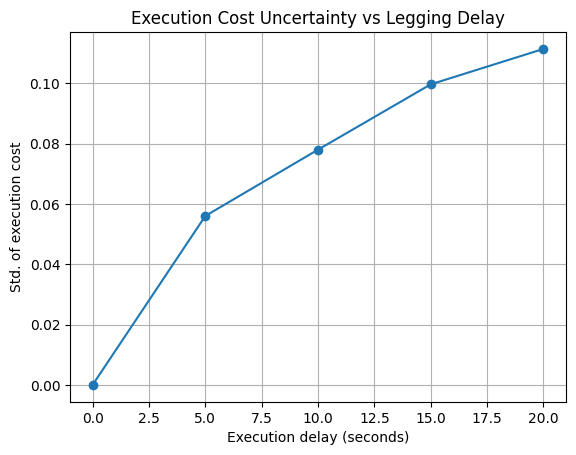

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(summary2.index, summary2["std_cost"], marker="o")
plt.xlabel("Execution delay (seconds)")
plt.ylabel("Std. of execution cost")
plt.title("Execution Cost Uncertainty vs Legging Delay")
plt.grid(True)
plt.show()


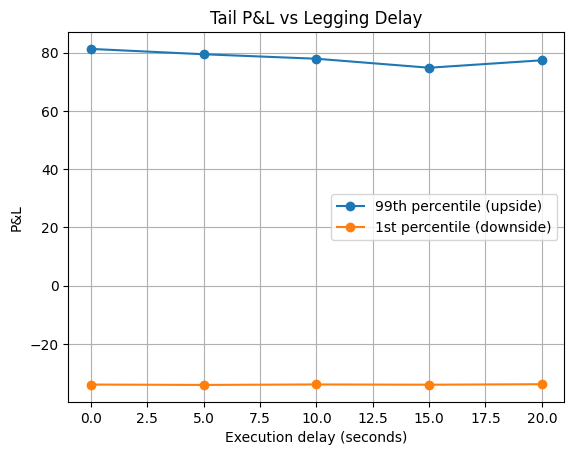

In [28]:
plt.figure()
plt.plot(summary2.index, summary2["p99_pnl"], marker="o", label="99th percentile (upside)")
plt.plot(summary2.index, summary2["p01_pnl"], marker="o", label="1st percentile (downside)")
plt.xlabel("Execution delay (seconds)")
plt.ylabel("P&L")
plt.title("Tail P&L vs Legging Delay")
plt.legend()
plt.grid(True)
plt.show()


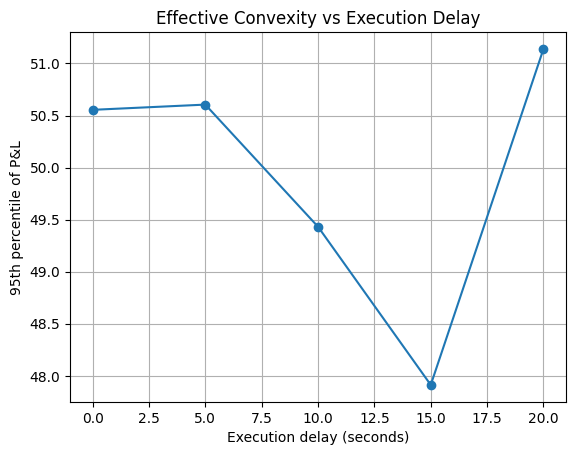

In [29]:
# Convexidad efectiva
plt.figure()
plt.plot(summary2.index, summary2["p95_pnl"], marker="o")
plt.xlabel("Execution delay (seconds)")
plt.ylabel("95th percentile of P&L")
plt.title("Effective Convexity vs Execution Delay")
plt.grid(True)
plt.show()


Robust tail measures confirm that execution delays do not enhance the upside potential of a long straddle. While the expected cost remains unchanged, execution delays increase price dispersion and slightly worsen downside tail outcomes. The apparent improvement in extreme maxima observed in raw simulations disappears when using quantiles, confirming that it is driven by Monte Carlo noise rather than economic effects.

We simulate the terminal payoff of an ATM long straddle under a geometric Brownian motion (GBM) for the underlying. Since the demo account does not provide live option quotes/greeks, we use a stylized simulation to characterize the payoff distribution and its convexity.

Assumptions:
- S_0 = K (ATM)
- r = 0
- sigma chosen as a proxy (historical)
- horizon : 30 trading days

In [30]:
import numpy as np
import pandas as pd

S0 = float(strike)   # usamos el strike seleccionado como proxy de spot
K  = float(strike)
r = 0.0
sigma = 0.20
T = 30/252
N_PATHS = 10000

np.random.seed(42)
Z = np.random.randn(N_PATHS)

ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

call_payoff = np.maximum(ST - K, 0.0)
put_payoff  = np.maximum(K - ST, 0.0)
straddle_payoff = call_payoff + put_payoff

df_unhedged = pd.DataFrame({
    "ST": ST,
    "CallPayoff": call_payoff,
    "PutPayoff": put_payoff,
    "StraddlePayoff": straddle_payoff
})

df_unhedged.describe()


,ST,CallPayoff,PutPayoff,StraddlePayoff
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,625.918008,17.224318,17.306310,34.530628
std,43.398533,26.366167,24.331451,26.286039
min,476.419175,0.000000,0.000000,0.002690
25%,596.188125,0.000000,0.000000,13.671324
50%,624.399475,0.000000,1.600525,28.908522
75%,654.111875,28.111875,29.811875,49.828072
max,818.853803,192.853803,149.580825,192.853803


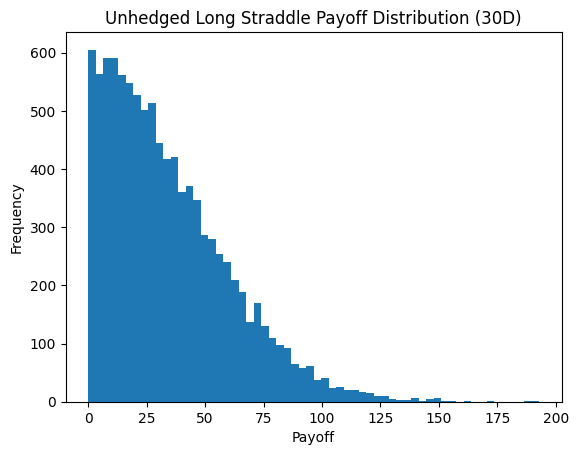

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_unhedged["StraddlePayoff"], bins=60)
plt.title("Unhedged Long Straddle Payoff Distribution (30D)")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.show()


The payoff distribution exhibits strong right skewness, reflecting the convex nature of a long straddle position.

The median payoff is strictly positive, while the lower tail is bounded near zero, consistent with the fact that losses are limited to the premium paid.

Large payoffs occur when the underlying experiences significant price movements over the 30-day horizon.

This profile highlights the positive Gamma exposure of the straddle: gains increase nonlinearly with the magnitude of the underlying move, regardless of direction.

## 6. Delta Hedging under the Black–Scholes Model

To isolate convexity effects and remove directional exposure, a delta-hedged version of the straddle is considered.

Under the Black–Scholes framework, option prices are given by:

$$
C(S,t) = BS(S, K, T-t, r, \sigma)
$$

The delta of a straddle is computed as:

$$
\Delta_{\text{straddle}} = \Delta_{\text{call}} + \Delta_{\text{put}}
$$

Dynamic delta hedging is implemented through periodic rebalancing of a position in the underlying asset. Option prices and greeks are computed using the `py_vollib` library to ensure numerical stability.

Simulation results show that:
- the expected P&L of a delta-hedged straddle is approximately zero,
- residual variability arises from discrete hedging and gamma exposure.


In [32]:
import numpy as np
import pandas as pd
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import delta as bs_delta

S0 = float(strike)
K = float(strike)
r = 0.0
sigma = 0.20

T_total = 30 / 252
steps = 30
dt = T_total / steps

n_paths = 2000
np.random.seed(42)

Z = np.random.randn(n_paths, steps)
S = np.zeros((n_paths, steps + 1))
S[:, 0] = S0

for t in range(steps):
    S[:, t+1] = S[:, t] * np.exp(
        (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t]
    )

# Initial straddle value
call0 = bs('c', S0, K, T_total, r, sigma)
put0  = bs('p', S0, K, T_total, r, sigma)
V0 = call0 + put0

delta0 = (
    bs_delta('c', S0, K, T_total, r, sigma)
  + bs_delta('p', S0, K, T_total, r, sigma)
)

shares0 = -delta0
cash0 = -V0 - shares0 * S0

final_values = []

for i in range(n_paths):
    shares = shares0
    cash = cash0

    for t in range(steps):
        St = S[i, t]
        T_remain = max(T_total - t * dt, 1e-8)

        delta_t = (
            bs_delta('c', St, K, T_remain, r, sigma)
          + bs_delta('p', St, K, T_remain, r, sigma)
        )

        target_shares = -delta_t
        d_shares = target_shares - shares
        cash -= d_shares * St
        shares = target_shares

    ST = S[i, -1]
    payoff = max(ST - K, 0) + max(K - ST, 0)
    final_values.append(payoff + shares * ST + cash)

df_hedged = pd.DataFrame({"FinalValue_Hedged": final_values})
df_hedged.describe()


,FinalValue_Hedged
count,2000.000000
mean,0.092813
std,5.453460
min,-23.648070
25%,-3.184336
50%,0.091195
75%,3.304366
max,23.093170


The mean P&L is close to zero, consistent with the theoretical prediction of the Black–Scholes model under perfect hedging assumptions.

The remaining dispersion reflects residual Gamma risk due to discrete rebalancing.

Compared to the unhedged straddle, the delta-hedged strategy exhibits significantly lower variance and a more symmetric P&L distribution.

This illustrates how delta-hedging removes directional exposure while transforming convexity into small stochastic gains and losses.

## Greeks Discussion

Greeks Interpretation for the Long Straddle Strategy

A long straddle position combines a long call and a long put at the same strike and maturity, resulting in a distinctive Greek profile:

Delta:
The net delta of an at-the-money straddle is approximately zero. However, delta becomes positive for upward moves and negative for downward moves, making the position highly sensitive to changes in the underlying price.

Gamma:
The straddle exhibits positive gamma. This convexity explains the payoff profile observed in the unhedged simulation: gains increase nonlinearly as the underlying moves away from the strike in either direction. Gamma is the primary driver of profitability for large price movements.

Vega:
The position has positive vega, benefiting from increases in implied volatility. Although implied volatility could not be directly observed due to market data limitations, this exposure is conceptually central to the strategy, particularly around macroeconomic events.

Theta:
The straddle has negative theta. In the absence of sufficient price movement or volatility expansion, the position loses value over time due to time decay.

In the delta-hedged simulation, directional exposure (delta) is neutralized through dynamic hedging. As a result, the remaining P&L is primarily driven by gamma and the discrete nature of the hedge, consistent with theoretical expectations.

## 8. SPY vs SPX: Conceptual Comparison

Using SPX options instead of SPY would introduce several differences:
- SPX options are European-style and cash-settled,
- contract size is significantly larger,
- theoretical consistency with Black–Scholes is improved,
- accessibility and flexibility are reduced.

For educational and simulation purposes, SPY options provide a more practical framework, while SPX options are better suited for institutional index-level exposure.


## 9. Limitations

The IBKR paper trading account does not provide live or delayed option market data. Consequently:
- implied volatility cannot be inferred from market prices,
- pricing relies on model-based assumptions.

Despite this limitation, the methodology remains internally consistent, and the codebase is fully prepared to integrate real market data when available.


## 10. Conclusion

This project provides a comprehensive analysis of a long straddle strategy on SPY options, combining API-based contract retrieval, quantitative simulation, and risk analysis.

The results highlight that:
- straddles offer convex exposure to volatility,
- delta hedging neutralizes directional risk,
- execution quality plays a critical role in multi-leg strategies.

In particular, execution (legging) risk affects higher moments of the P&L distribution, reducing effective convexity even when expected outcomes remain unchanged.


In [33]:
ib.disconnect()
print("Disconnected:", not ib.isConnected())


Disconnected: True
